In [8]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import LinearOperator, eigsh
import matplotlib.pyplot as plt

## Part A: transverse Ising model $(J, h)$ phase diagram (without symmetries)

First, let us form the many-body Hamiltonian of the form ($J = 1$, periodic BC):
$$H = \sum\limits_{i=0}^{N - 1} \sigma_i^z \sigma_{i + 1}^z + h \sum\limits_i \sigma^x.$$

First, please construct the first term:

In [9]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.diag([1, -1])
sigma_0 = np.eye(2)
N = 8 # the number of spins in the system

def fill_identities(h_local, begin, end):
    if end <= begin:
        return h_local
    return np.kron(np.eye(2 ** (end - begin)), h_local)

print(np.eye(3))

def hamiltonian_j(N):
    H = np.zeros((2 ** N, 2 ** N), dtype=np.complex128)  # shape of the full many-body N-spins hamiltonian
    for i in range(N - 1):  # loop over all spins except the boundary pair
        h_local = np.eye(1, dtype=np.complex128)
        h_local = fill_identities(h_local, i + 2, N) # prepare tensor product of identities to the right of (sigma_z x sigma_z)

        h_local = np.kron(sigma_z, h_local)
        h_local = np.kron(sigma_z, h_local)

        h_local = fill_identities(h_local, 0, i) # multiply h_local by i identities to the left
        H += h_local

    h_local = sigma_z  # now fix the boundary
    h_local = fill_identities(h_local, 1, N - 1)
    h_local = np.kron(sigma_z, h_local)
    H += h_local
    return H.real

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Then please construct the transverse field term with $h = 1$:

In [10]:
def hamiltonian_h(N):
    H = np.zeros((2 ** N, 2 ** N), dtype=np.complex128)  # shape of the full many-body N-spins hamiltonian
    for i in range(N):  # the h-term
        h_local = np.eye(1, dtype=np.complex128)
        h_local = fill_identities(h_local, i + 1, N) # prepare identities to the right of sigma_x
        h_local = np.kron(sigma_x, h_local)
        h_local = fill_identities(h_local, 0, i) # multiply h_local by identities to its left
        H += h_local
    return H.real

In [11]:
H_j = hamiltonian_j(N)  # obtain the j-part (remains unchanged)
H_h = hamiltonian_h(N)  # obtain normalized h--part

Now obtain the low-energy spectrum of the model:

In [12]:
# obtain the low-energy spectrum of the model
n_low_levels = 10
h_vals = np.linspace(-2, 2, 40)
levels = []

for h in h_vals:
    H = H_j + h * H_h # construct the total Hamiltonian
    energies_h, _ = np.linalg.eigh(H)
    levels.append(energies_h[:n_low_levels])

levels = np.array(levels)

Plot the obtained energy spectrum as a function of $h / J$:

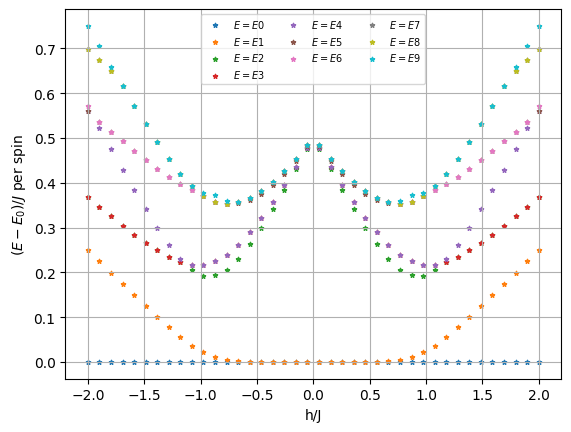

In [13]:
for level in range(n_low_levels):
    plt.scatter(h_vals, levels[:, level] / N - levels[:, 0] / N, marker='*', s = 10.,label='$E = E%s$' % (level))

plt.legend(fontsize=7,ncol=3)
plt.grid(True)
plt.xlabel('h/J')
plt.ylabel('$(E - E_0) / J$ per spin')
plt.show()

For $|h| < J$, the system is in the antiferromagnetic phase, the lowest two states with momenta $k = 0$ and $k = \pi$ are degenerate (you can check this by expressing the Hamiltonian in the basis of eigenstates of the translation operator $\hat{T}$ and diagonalizing it in this basis). For $|h| > J$ the system undergoes a phase transition to the paramagnetic phase, where this degeneracy is broken.

## Part B

Instead of constructing a dense matrix, you can also use the bit representation to implement the action of the Hamiltonian in terms of bitwise operations. This function can be used as a scipy linear operator in the Lanczos eigenvalue solver. This procedure is particularly useful for larger problems.

To employ the bitstring represenation: the basis element number $k$ should be written in the binary representation to get the individual spin orientations. For instance, the basis element $k = 415 = 256 + 128 + 16 + 8 + 4 + 2 + 1$ with $N = 10$ spins would correspond to the bitstring (0, 1, 1, 0, 0, 1, 1, 1, 1, 1), meaning, 0-th, 3-rd and 4-th spins are down, others up.

We reuse our the code from last week for computations on binary strings:

In [14]:
def shift_right(spins: int, shift: int, N: int) -> int:
    for j in range(0,shift):
        spins = (spins>>1) + 2**(N-1)*(spins%2)
    return spins

def shift_left(spins:int, shift:int, N:int) -> int:
    for j in range(0, shift):
        if spins >= 2**(N-1):
            spins = (spins<<1) - (2**(N)) +1
        else:
            spins = spins<<1
    return spins

def count_upspins(i:int) -> int:
    return format(i,'b').count('1')

def spin_at_j(i: int, j: int) -> int:
    return (i>>j)%2

def flip_spin(i: int, j: int) -> int:
    return (1<<j)^i

def flip_all_spins(i: int, N: int) -> int:
    return i^(2**N-1)

Then, we can construct the action of the Hamiltonian on the states as bitwise operations. To implement the action of the Hamiltonian as a Scipy Linear Operator, we want to define the operation $\vec{y}=H\vec{x}$.

To this end, note that the wavefunction is written as $|\psi\rangle=\sum_{i=0}^{2^N-1} x[i]|i\rangle$, where $|i\rangle$ is the index corresponding to a spin configuration and $x[i]$ is the corresponding weight. Since the $\sigma_z$ term in the Hamiltonian is diagonal, we have $y[i]=E_z(i)x[i]$ under the action of this term, where $E_z(i)$ is the eigenvalue of the diagonal term associated with state $|i\rangle$. The $h$ (i.e. $\sigma_x$) term has matrix elements between the different indices, so we have $y[i]=H_{ij}x[j]$.


In [15]:
def act_hz(x):
    y = np.zeros(2 ** N)
    for spins in range(2 ** N):
        shifted = shift_right(spins, 1, N)
        num_different = count_upspins(spins ^ shifted)
        ez = num_different * (-1) + (N - num_different) * (+1)
        y[spins] = ez * x[spins]
    return y

In [16]:
def act_h(x, h):
    y = np.zeros(2 ** N)
    for spins in range(2 ** N):
        #yj = 0
        for s in range(N):
            flip_s = (1 << s) ^ spins   # flip a single spin at site s
            y[flip_s] += x[spins]

    return h * y

Now we're in a good position to implement the Lanczos algorithm -- does this give the same result as Part A?

In [17]:
n_low_levels = 10
h_vals = np.linspace(-2, 2, 40)
levels = []

for h in h_vals:
    def act_H(vec):
        return act_hz(vec) + act_h(vec, h)

    A = LinearOperator((2**N, 2**N), matvec=act_H)
    energies_h, _ = eigsh(A, k=n_low_levels+2, which='SA') # ask Lanczos for more eigenvalues than needed -- fix convergence issues
    levels.append(energies_h[:n_low_levels])

levels = np.array(levels)

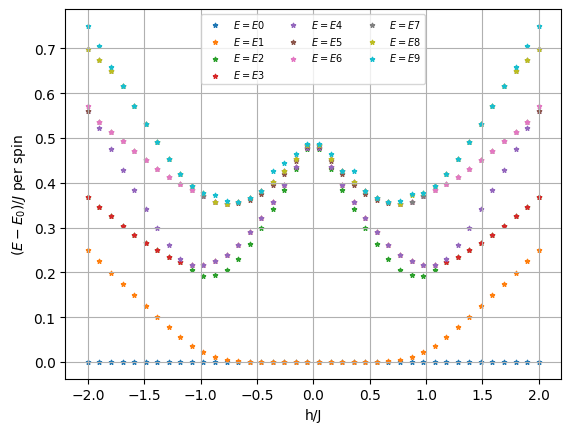

In [18]:
for level in range(n_low_levels):
    plt.scatter(h_vals, levels[:, level] / N - levels[:, 0] / N, marker='*', s = 10.,label='$E = E%s$' % (level))

plt.legend(fontsize=7,ncol=3)
plt.grid(True)
plt.xlabel('h/J')
plt.ylabel('$(E - E_0) / J$ per spin')
plt.show()

## Part C

The transverse field Ising Hamiltonian has many symmetries. Finding the symmetry essentially means finding another basis where the hamiltonian takes the _block-diagonal form_. Among the possible symmetries, there are:

1) Flipping all spins with the operator $X = \otimes_i \sigma_i^x$,

2) Total magnetisation conservation with the operator $M = \sum\limits_i \sigma_i^z$ (only at $h = 0$),

3) Translation symmetry $T: i \to i + 1\,\text{mod N}$ with a rather non-local operator form.

If the Hamiltonian has a symmetry $[H, A] = 0$ (block-diagonal form in some basis), $H$ and $A$ can be diagonalized simultaneously. This means that the Hamiltonian does not mix the eigenstates from sectors with different eigenvalues of $A$. This fact allows one to search for $H$ eigenstates in the sectors of $A$ eigenvalues one-by-one, which might significantly reduce the ED-complexity.

At the end of this first exercise, please constuct the operators for the symmetries (1) and (2) and explicitly check that $[\hat H, \hat A] = 0$ for both of them.

We start with the flipping symmetry:

In [19]:
A = np.eye(1)
H = H_j + H_h * np.random.uniform(-2, 2)  # hamiltonian with arbitrary value of field h

# construct the A--operator
for i in range(N):
    A = np.kron(sigma_x, A)

assert np.allclose(H.dot(A), A.dot(H))

We proceed with the total magnetisation operator M, which is the symmetry only for $h = 0$:

In [20]:
M = np.zeros((2 ** N, 2 ** N))
H = H_j + H_h * np.random.uniform(-1, 1)  # hamiltonian with arbitrary value of field h

# construct the M--operator
for i in range(N):
    m_local = np.eye(1)
    m_local = fill_identities(m_local, i+1, N)
    m_local = np.kron(sigma_z, m_local)
    m_local = fill_identities(m_local, 0, i)
    M += m_local

assert not np.allclose(H.dot(M), M.dot(H))
assert np.allclose(H_j.dot(M), M.dot(H_j))